# 1. EXTRACT DATA FROM REGIONAL CLIMATE MODELS - RCA4

In [1]:
import os
import numpy as np
import math
from   numpy import dtype
import pandas as pd

import datetime as dt
from   datetime import datetime
import netCDF4 as nc
from   netCDF4 import Dataset, date2index, num2date, num2date, date2num
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
def rotated_nonrotated(location,option,rotpole):
    
    # Check with CORDEX domain; 
    # A) For rotated polar RCMs (in rotated coordinates)    : TLC (143.92; 34.76)
    # A) For non-rotated polar RCMs (in actual coordinates) : TLC (273.26; 18.50)

    lon = location[0] * math.pi / 180; # Convert degrees to radians
    lat = location[1] * math.pi / 180;

    theta = (90 + rotpole[1])           # Rotation around y-axis
    phi   = rotpole[0];                 # Rotation around z-axis
    phi   = (phi * math.pi) / 180       # Convert degrees to radians
    theta = (theta * math.pi) / 180
    x = math.cos(lon) * math.cos(lat)
    y = math.sin(lon) * math.cos(lat)
    z = math.sin(lat)

    """
    option: {1: Regular to Rotated
             2: Rotated to Regular}
    """

    if option == 1:   #Regular -> Rotated
        x_new = math.cos(theta) * math.cos(phi) * x + math.cos(theta) * math.sin(phi) * y + math.sin(theta) * z
        y_new = -math.sin(phi) * x + math.cos(phi) * y
        z_new = -math.sin(theta) * math.cos(phi) * x - math.sin(theta) * math.sin(phi) * y + math.cos(theta) * z

        lon_new = math.atan2(y_new, x_new) #Convert cartesian back to spherical coordinates
        lat_new = math.asin(z_new)
        
        lon_new = (lon_new * 180) / math.pi; # Convert radians back to degrees
        lat_new = (lat_new * 180) / math.pi;        

    else:   #Rotated -> Regular
        phi = -phi
        theta = -theta
        x_new = math.cos(theta) * math.cos(phi) * x + math.sin(phi) * y + math.sin(theta) * math.cos(phi) * z
        y_new = -math.cos(theta) * math.sin(phi) * x + math.cos(phi) * y - math.sin(theta) * math.sin(phi) * z
        z_new = -math.sin(theta) * x + math.cos(theta) * z;
        
        lon_new = math.atan2(y_new, x_new) #Convert cartesian back to spherical coordinates
        lat_new = math.asin(z_new)
    

        lon_new = (lon_new * 180) / math.pi; # Convert radians back to degrees
        lat_new = (lat_new * 180) / math.pi;
    
        lon_new = (lon_new + 360) % 360;

    grid_out = np.array([lon_new,lat_new])
    
    return grid_out

def date(f,dateyear):
    nc_time    = f.variables["time"]
    time_start = date2index(dt.datetime(dateyear[0],1,1,12,0,0)  , nc_time, calendar = nc_time.calendar, select="nearest")
    time_end   = date2index(dt.datetime(dateyear[1],12,31,12,0,0), nc_time, calendar = nc_time.calendar, select="nearest")
    dates      = num2date(nc_time[time_start:time_end+1], units=nc_time.units, calendar=nc_time.calendar)
    return (dates)
    
def dateind(f,dateind):
    nc_time    = f.variables["time"]
    time_start = date2index(dt.datetime(dateind[0],1,1,12,0,0)  , nc_time, calendar = nc_time.calendar, select="nearest")
    time_end   = date2index(dt.datetime(dateind[1],12,31,12,0,0), nc_time, calendar = nc_time.calendar, select="nearest")
    ind = np.array([time_start,time_end+1])
    return ind    



In [3]:
def extract_rcm_button(rcm_folder, var, model, scenario, ensemble, years, coords):
    
    file_name = f'{var}_SAM-44_{model}_{scenario}_{ensemble}_SMHI-RCA4_v3_day'
    
    file_names = []
    
    for year in np.arange(years[0],years[1],5):

        file_name_i = f'{file_name}_{year}0101-{year+4}1231.nc'

        file_names.append(file_name_i)
        
        
    rcm_path  = os.path.join(rcm_folder,f'{scenario}')
  
    # From non-rotated coords to rotated : nearest GRID      
    rotpole   = np.array([123.94,-70.6]) # Search in metadata
    option    = 1        
    rotated_coords = []
        
    lon_lat = np.array([coords[0]+360,coords[1]])
    rotated = rotated_nonrotated(lon_lat,option,rotpole) #[lon, lat]  

    grid_index =  []
        
    # GRIDS
     
    # Historical
    os.chdir(rcm_path)
    cordex_rcm = nc.MFDataset(file_names)

    rlat = cordex_rcm.variables['rlat'][:]  # Get r_latitud
    rlon = cordex_rcm.variables['rlon'][:]  # Get r_longitude
            
    lats_dif = np.abs(rlat - rotated[1])    
    lons_dif = np.abs(rlon - rotated[0])
               
    idx_lats = np.argsort(lats_dif)[0]      # np.argsor() Returns an array with the position from the smallest to the biggest
    idx_lons = np.argsort(lons_dif)[0]
    
    grid = [idx_lats, idx_lons]

    ilat = grid[0] 
    ilon = grid[1]
            
    # Historical        
    period_date  = [years[0],years[1]]
    ind_time     = dateind(cordex_rcm,period_date) 
    datesC       = date(cordex_rcm,period_date)  
            
    data = cordex_rcm.variables[f'{var}'][ind_time[0]:ind_time[1],ilat,ilon]
        
    return data
        

In [11]:
def extract_variables(rcm_folder, model, scenario, ensemble, years, coords, output_folder):
    
    variables = ['clt', 'evspsbl', 'hurs'
                 , 'hus850', 'huss', 'pr' 
                 ,'prw', 'ps', 'rlds', 'sfcWind', 'sund', 'tas', 'tasmax'
                 ,'tasmin', 'uas', 'vas', 'zg200','zg500'
                ]

    #variables = ['clt', 'hurs', 'hus850', 'huss', 'pr' ,'prw', 'rlds', 'tas', 'vas', 'zg200']
    
    
    data_list= []
    for var in variables:
        
        data_var = extract_rcm_button(rcm_folder, var, model, scenario, ensemble, years, coords)
        data_list.append(data_var)

    
    date = pd.date_range(f'{years[0]}-01-01',
                         periods = len(data_list[0]),
                         freq='d')
    
    variables_data = pd.DataFrame(np.array(data_list).T,columns=variables,index=pd.to_datetime(date))
    
    os.chdir(output_folder)
    variables_data.to_csv(f'data_SAM-44_{model}_{scenario}_{ensemble}_SMHI-RCA4_v3_day.csv')        
    return variables_data

# 1.1 GET CLIMATE DATA

In [12]:
var      = 'pr'
model    = 'ICHEC-EC-EARTH'
scenario = 'historical'
ensemble = 'r12i1p1'
years = [1976,2005]
coords = [-63.70173,-18.2428]
rcm_folder = r"D:\CORDEX"
output_folder = "D:\CORDEX\data_variables"

df = extract_variables(rcm_folder, model, scenario, ensemble, years, coords, output_folder)

In [6]:
var      = 'pr'
model    = 'ICHEC-EC-EARTH'
scenario = 'rcp85'
ensemble = 'r12i1p1'
years = [2036,2065]
coords = [-63.70173,-18.2428]
rcm_folder = r"D:\CORDEX"
output_folder = "D:\CORDEX\data_variables"

df_cc = extract_variables(rcm_folder, model, scenario, ensemble, years, coords, output_folder)

# 2. EXPLORATORY DATA ANALYSIS

## 2.1 Matriz de correlación

Text(0.5, 1.0, 'Correlation Heatmap')

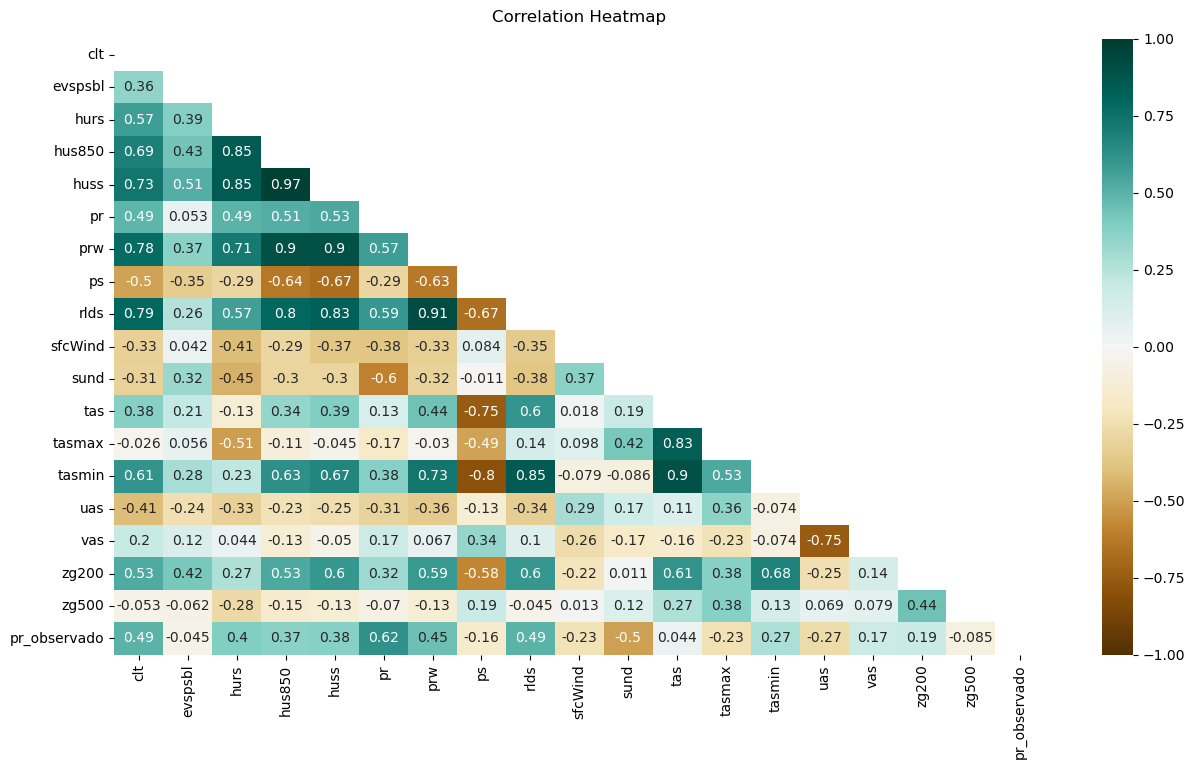

In [13]:
df = df.sort_values(by=['clt'], ascending=False)

# Get observed data
data_obs = pd.read_csv(r"cangostura_AVG_pr_historical_1976_2005.csv").iloc[:,1]
data_obs_arr = np.array(data_obs.sort_values(ascending=False))
df['pr_observado'] = data_obs_arr

# Increase the size of the heatmap.
plt.figure(figsize=(15, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask,vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## 2.2 EDA variables seleccionadas

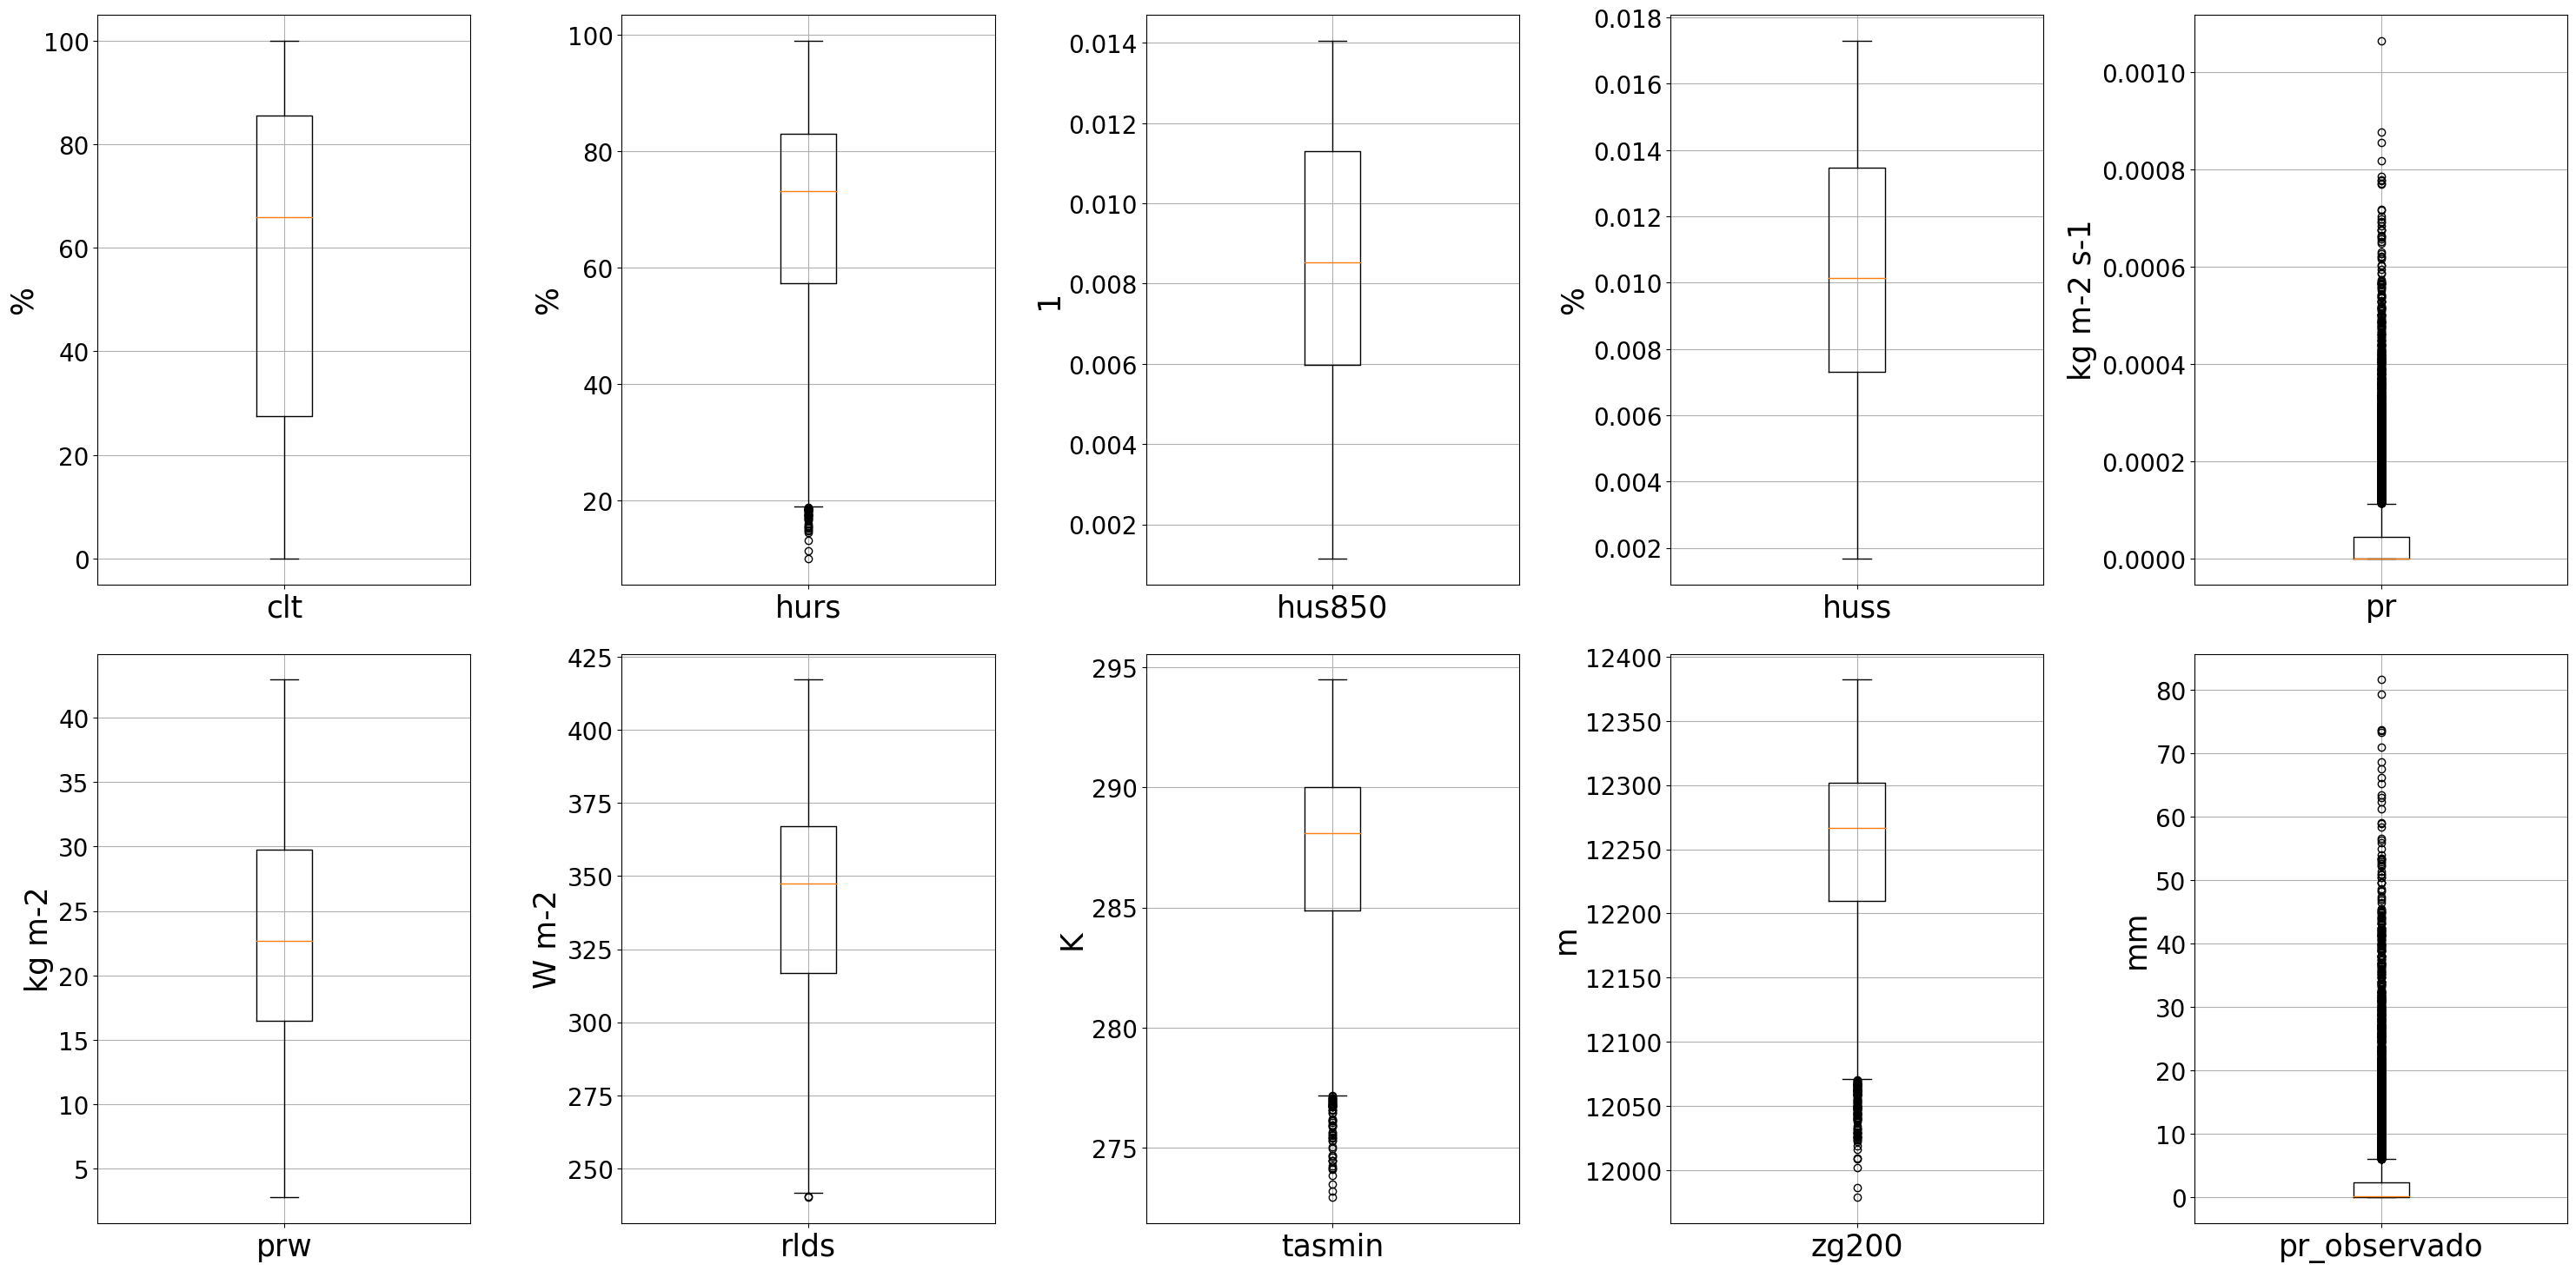

In [14]:
df_campos_seleccionados = pd.DataFrame(df[['clt', 'hurs', 'hus850', 
                                           'huss', 'pr', 'prw', 
                                           'rlds', 'tasmin', 'zg200'
                                           , 'pr_observado']])

fig1, axs = plt.subplots(2,5, figsize=(30,15))

unidades = ['%', '%', '1','%', 'kg m-2 s-1', 
            'kg m-2', 'W m-2', 'K', 'm', 'mm' ]

c = 0
for j in range(2):
    for i in range(5):   
        axs[j,i].boxplot(df_campos_seleccionados.iloc[:,c].dropna())
        axs[j,i].set_xticklabels([df_campos_seleccionados.columns[c]], fontsize=25)
        axs[j,i].tick_params(axis='y', labelsize=20)
        axs[j,i].set_ylabel(unidades[c], fontsize=25)
        axs[j,i].grid()
        c+=1

fig1.tight_layout(pad=2.0)
plt.show()

# 3. SAVE DATA

In [15]:
plt.savefig(f'cordex_matrix_corr_{model}_{scenario}_{years[0]}_{years[1]}.png', bbox_inches='tight')
fig1.savefig(f'cordex_boxplot_{model}_{scenario}_{years[0]}_{years[1]}.png', bbox_inches='tight')
df.to_csv(f'cordex_{model}_{scenario}_{years[0]}_{years[1]}.csv') 

<Figure size 640x480 with 0 Axes>